In [1]:
import os
import glob
import datetime
import statistics
import numpy as np
import pandas as pd
import import_ipynb
from marcap import marcap_data
import FinanceDataReader as fdr
import matplotlib.pyplot as plt

In [2]:
from qp import get_stocks # 1/PBR + GP/A
#from ncav import get_stocks # NCAV
#from super_value import get_stocks
#from super_quality import get_stocks

importing Jupyter notebook from qp.ipynb
importing Jupyter notebook from common.ipynb


In [3]:
MODEL_NAME = 'qp'
DATA_DIR = 'data/daily/8-1'

In [4]:
df_account = pd.DataFrame(columns=['start_date', 'end_date', 'filepath'])
filepaths = glob.glob(DATA_DIR + "/*.csv")
filepaths = sorted(filepaths)

days = []
for i in range(len(filepaths)):
    if i < len(filepaths) - 1: # exclude last item
        start_date =  os.path.basename(filepaths[i])[:-4]
        end_date =  os.path.basename(filepaths[i + 1])[:-4]
        
        day = {'start_date':start_date, 'end_date':end_date, 'filepath':filepaths[i]}
        days.append(day)

df_account = df_account.append(days)

In [5]:
df_account

,start_date,end_date,filepath
0,2002-08-01,2003-08-01,data/daily/8-1/2002-08-01.csv
1,2003-08-01,2004-08-02,data/daily/8-1/2003-08-01.csv
2,2004-08-02,2005-08-01,data/daily/8-1/2004-08-02.csv
3,2005-08-01,2006-08-01,data/daily/8-1/2005-08-01.csv
4,2006-08-01,2007-08-01,data/daily/8-1/2006-08-01.csv
5,2007-08-01,2008-08-01,data/daily/8-1/2007-08-01.csv
6,2008-08-01,2009-08-03,data/daily/8-1/2008-08-01.csv
7,2009-08-03,2010-08-02,data/daily/8-1/2009-08-03.csv
8,2010-08-02,2011-08-01,data/daily/8-1/2010-08-02.csv
9,2011-08-01,2012-08-01,data/daily/8-1/2011-08-01.csv


In [6]:
# 연도별 종목을 구한다.
df_account['stocks'] = df_account.apply(lambda x: get_stocks(x.filepath, x.start_date), axis=1)

------------------------------
2002-08-01 data/daily/8-1/2002-08-01.csv
전체 1576
지주사, 금융사 제외 1477


common.ipynb:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  "\n",


국외주식 제외 1477
유동비율 > 1 972
가격정보 없는 기업 제외 686
선정 기업 수 30
------------------------------
2003-08-01 data/daily/8-1/2003-08-01.csv
전체 1668
지주사, 금융사 제외 1569
국외주식 제외 1569
유동비율 > 1 1002
가격정보 없는 기업 제외 719
선정 기업 수 30
------------------------------
2004-08-02 data/daily/8-1/2004-08-02.csv
전체 1716
지주사, 금융사 제외 1614
국외주식 제외 1614
유동비율 > 1 1034
가격정보 없는 기업 제외 755
선정 기업 수 30
------------------------------
2005-08-01 data/daily/8-1/2005-08-01.csv
전체 1812
지주사, 금융사 제외 1708
국외주식 제외 1707
유동비율 > 1 1123
가격정보 없는 기업 제외 800
선정 기업 수 30
------------------------------
2006-08-01 data/daily/8-1/2006-08-01.csv
전체 1861
지주사, 금융사 제외 1754
국외주식 제외 1752
유동비율 > 1 1207
가격정보 없는 기업 제외 883
선정 기업 수 30
------------------------------
2007-08-01 data/daily/8-1/2007-08-01.csv
전체 1952
지주사, 금융사 제외 1841
국외주식 제외 1835
유동비율 > 1 1261
가격정보 없는 기업 제외 940
선정 기업 수 30
------------------------------
2008-08-01 data/daily/8-1/2008-08-01.csv
전체 2046
지주사, 금융사 제외 1930
국외주식 제외 1920
유동비율 > 1 1279
가격정보 없는 기업 제외 980
선정 기업 수 30
---------------------------

In [20]:
# 연도별 수익률을 구한다.
df_account['yield'] = 0.0
df_account['yields'] = 0.0
df_account['yields'] = df_account['yields'].astype('object')
df_account['delisted'] = 0
df_account['delisted_stocks'] = df_account['yields'].astype('object')

for i in range(len(filepaths)):
    if i < len(filepaths) - 1: # exclude last item
        start_date = df_account.iloc[i].start_date
        end_date = df_account.iloc[i].end_date
        
        df_this_year = pd.read_csv(filepaths[i], dtype={"기업코드":"string", "종목코드":"string"})[['종목코드', '주가']]
        df_next_year = pd.read_csv(filepaths[i + 1], dtype={"기업코드":"string", "종목코드":"string"})[['종목코드', '주가']]
        
        stocks = df_account.iloc[i].stocks   
        yields = []
        
        # 종목별 수익률, 상장폐지 기업 수를 구한다.
        delisted = 0 # 상장폐지 기업 수
        delisted_stocks  = []
        for stock in stocks:
            start_price = df_this_year[df_this_year['종목코드'] == stock]['주가'].iloc[0]
            end_price = df_next_year[df_next_year['종목코드'] == stock]['주가']
            
            if len(end_price) == 0:
                end_price = 0
            else:                    
                end_price = end_price.fillna(0) 
                end_price = end_price.iloc[0]
                
            if end_price == 0: # 가격 정보가 없을 경우 상폐
                delisted += 1
                delisted_stocks.append(stock)
            
            # get yield
            yields.append(end_price / start_price)

        # stock 수익률들의 avg가 total 수익률이 된다. (동일 비중이기 때문에)
        mean_yields = statistics.mean(yields)
        df_account.at[i, 'yield'] = mean_yields
        df_account.at[i, 'yields'] = yields
        df_account.at[i, 'delisted'] = delisted
        df_account.at[i, 'delisted_stocks'] = delisted_stocks
        
        print(start_date, '~', end_date, ":", mean_yields)
        
        #break

2002-08-01 ~ 2003-08-01 : 0.8392384120164176
2003-08-01 ~ 2004-08-02 : 0.9416153626013801
2004-08-02 ~ 2005-08-01 : 3.1598371147100783
2005-08-01 ~ 2006-08-01 : 1.2031411026186385
2006-08-01 ~ 2007-08-01 : 2.2122941766469997
2007-08-01 ~ 2008-08-01 : 0.8301652737091127
2008-08-01 ~ 2009-08-03 : 1.2373605512962753
2009-08-03 ~ 2010-08-02 : 1.3750739755780743
2010-08-02 ~ 2011-08-01 : 2.2948935253240084
2011-08-01 ~ 2012-08-01 : 1.470708317715634
2012-08-01 ~ 2013-08-01 : 1.176610280873401
2013-08-01 ~ 2014-08-01 : 1.2302406969914133
2014-08-01 ~ 2015-08-03 : 2.065148987814501
2015-08-03 ~ 2016-08-01 : 1.559306412408173
2016-08-01 ~ 2017-08-01 : 1.0486625855636469
2017-08-01 ~ 2018-08-01 : 1.8418660524494648
2018-08-01 ~ 2019-08-01 : 1.482481401557163


In [21]:
df_account['total'] = df_account['yield'].cumprod()

In [22]:
df_account['cagr'] = 0.0
for i, row in enumerate(df_account.iterrows()):
    df_account.at[i, 'cagr'] = pow(row[1]['total'], 1/(i+1))

In [23]:
def get_win_rate(yield_rates):
    return sum([yield_rate > 1.0 for yield_rate in yield_rates]) / len(yield_rates)

df_account['win_rate'] = df_account.apply(lambda x: get_win_rate(x['yields']), axis=1)

In [24]:
df_account['best_corp'] = df_account.apply(lambda x: max(x['yields']), axis=1)
df_account['worst_corp'] = df_account.apply(lambda x: min(x['yields']), axis=1)

In [25]:
df_account['best_stock_code'] = df_account.apply(lambda x: x['stocks'][np.argmax(x['yields'])], axis=1)
df_account['worst_stock_code'] = df_account.apply(lambda x: x['stocks'][np.argmin(x['yields'])], axis=1)

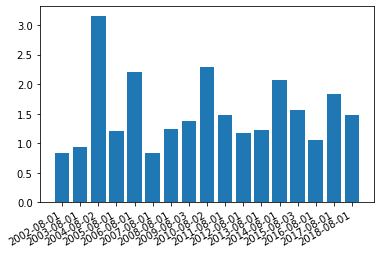

In [26]:
fig, ax = plt.subplots()
plt.bar(df_account['start_date'], df_account['yield'])
fig.autofmt_xdate()
plt.show()

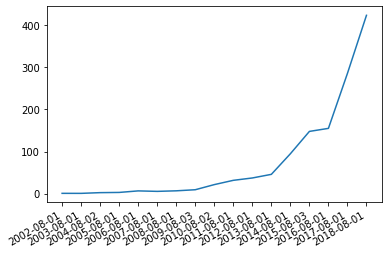

In [27]:
fig, ax = plt.subplots()
ax.plot_date(df_account['start_date'], df_account['total'], marker='', linestyle='-')
fig.autofmt_xdate()
plt.show()

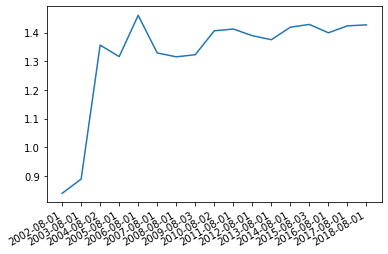

In [28]:
fig, ax = plt.subplots()
ax.plot_date(df_account['start_date'], df_account['cagr'], marker='', linestyle='-')
fig.autofmt_xdate()
plt.show()

In [29]:
1 - min(df_account['yield'])

0.16983472629088725

In [30]:
max(df_account['yield'])

3.1598371147100783

In [34]:
# 가격 정보가 없는 경우 상폐로 처리했음. 실제로 상폐까지는 아니고 거래정지인 경우가 있음
sum(df_account['delisted'])

8

In [32]:
df_account

,start_date,end_date,filepath,stocks,yield,yields,out,total,cagr,win_rate,best_corp,worst_corp,best_stock_code,worst_stock_code,delisted,delisted_stocks
0,2002-08-01,2003-08-01,data/daily/8-1/2002-08-01.csv,"[010600, 025880, 014570, 027040, 005610, 00737...",0.839238,"[0.8875739644970414, 0.9055793991416309, 1.297...",0,0.839238,0.839238,0.200000,1.426829,0.084483,027040,012620,0,[]
1,2003-08-01,2004-08-02,data/daily/8-1/2003-08-01.csv,"[010600, 014100, 025880, 004540, 008290, 03286...",0.941615,"[0.7766666666666666, 0.7477876106194691, 0.606...",0,0.790240,0.888954,0.266667,4.793814,0.056426,050120,007770,0,[]
2,2004-08-02,2005-08-01,data/daily/8-1/2004-08-02.csv,"[010600, 017680, 032860, 016920, 025880, 01410...",3.159837,"[1.6251788268955651, 1.96875, 3.08227848101265...",0,2.497029,1.356671,1.000000,20.588235,1.256545,050050,045060,0,[]
3,2005-08-01,2006-08-01,data/daily/8-1/2005-08-01.csv,"[010600, 017680, 046310, 045060, 016920, 07965...",1.203141,"[2.183098591549296, 1.812169312169312, 1.36842...",0,3.004278,1.316543,0.733333,2.261538,0.118033,024950,014570,0,[]
4,2006-08-01,2007-08-01,data/daily/8-1/2006-08-01.csv,"[068290, 025880, 000440, 016920, 045060, 00811...",2.212294,"[2.0201729106628243, 1.8651162790697675, 1.607...",0,6.646347,1.460551,1.000000,6.934959,1.095602,010960,079650,0,[]
5,2007-08-01,2008-08-01,data/daily/8-1/2007-08-01.csv,"[017680, 010600, 045060, 045660, 025880, 02495...",0.830165,"[0.5589519650655022, 0.04375, 0.78085642317380...",0,5.517567,1.329305,0.233333,2.214286,0.043750,041830,010600,0,[]
6,2008-08-01,2009-08-03,data/daily/8-1/2008-08-01.csv,"[011080, 078520, 014570, 046310, 079650, 00536...",1.237361,"[0.6292517006802721, 3.630252100840336, 0.9611...",0,6.827219,1.315763,0.400000,3.630252,0.230814,078520,005360,0,[]
7,2009-08-03,2010-08-02,data/daily/8-1/2009-08-03.csv,"[011080, 017680, 010470, 033340, 079650, 00798...",1.375074,"[0.9081081081081082, 1.1848101265822786, 1.621...",0,9.387932,1.323035,0.766667,3.733333,0.135747,048770,008700,0,[]
8,2010-08-02,2011-08-01,data/daily/8-1/2010-08-02.csv,"[011080, 033340, 032860, 088790, 011090, 01279...",2.294894,"[0.8857142857142857, 1.0733333333333333, 22.61...",0,21.544303,1.406527,0.700000,22.615385,0.106838,032860,017680,0,[]
9,2011-08-01,2012-08-01,data/daily/8-1/2011-08-01.csv,"[011080, 038320, 033340, 044380, 091440, 04631...",1.470708,"[1.7473118279569892, 0.0, 1.1770186335403727, ...",1,31.685386,1.412817,0.633333,5.195122,0.000000,031860,038320,1,[038320]


In [ ]:
df_account.to_csv('log/' + MODEL_NAME + '-' + os.path.basename(DATA_DIR) + '.csv', index=False)

In [ ]:
1